In [96]:
import pandas as pd
import numpy as np
from numpy import log2 as log
import matplotlib.pyplot as plt
import math
import pprint

In [95]:
'''
Preprocessing data.

Load the csv file into pandas dataframe
'''

def GetData(target_attribute):
    #~/Documents/SMAI/Assignment1/SamplePlayData.csv
    #~/Documents/SMAI/Assignment1/decision_Tree/train.csv
    data = pd.read_csv('~/Documents/SMAI/Assignment1/decision_Tree/train.csv')
    dataframe = pd.DataFrame(data)
    
    num_of_rows = math.floor(len(dataframe[target_attribute]) * 0.8)
    #dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    df = dataframe.copy()
    dataframe = dataframe.head(num_of_rows)  #Train
    test_data = df.tail(len(df[target_attribute]) - num_of_rows) #Test
    actual_y = test_data[target_attribute].values
    test_data = test_data.drop(target_attribute, 1)
    #train_data.sort() # sorts data
    #test_data.sort()
   
    columns = list(dataframe.columns)
    columns.remove(target_attribute)
    return dataframe,test_data,actual_y,columns

In [3]:
def MissClassFormula(prob):
    return min(prob,1-prob)

In [4]:
def MissClass(dataframe,target_attribute):
    unique = list(dataframe[target_attribute].unique())
    return (GiniFormula(len(dataframe[target_attribute][dataframe[target_attribute] == unique[0]])/len(dataframe[target_attribute])))

In [5]:
'''
Works like  Information Gain
'''
def MissClassAttr(dataframe,attribute,target_attribute,MR):
    target_variables = list(dataframe[target_attribute].unique())
    unique_values = dataframe[attribute].unique()
    M=0
    for attr in unique_values:
        prob = (len(dataframe[attribute][dataframe[attribute] == attr][dataframe[target_attribute] == target_variables[0]]))/len(dataframe[attribute][dataframe[attribute]==attr])
        M += (len(dataframe[attribute][dataframe[attribute] == attr])/len(dataframe[attribute]))*GiniFormula(prob)
    return MR-M

In [6]:
'''
used by GiniAttr and Gini functions
'''
def GiniFormula(prob):
    if prob == 0:
        return 0
    G = 2 * prob * (1-prob)
    return G

In [7]:
def Gini(dataframe,target_attribute):
    unique = list(dataframe[target_attribute].unique())
    return (GiniFormula(len(dataframe[target_attribute][dataframe[target_attribute] == unique[0]])/len(dataframe[target_attribute])))

In [8]:
'''
Works like  Information Gain
'''
def GiniAttr(dataframe,attribute,target_attribute,GI):
    target_variables = list(dataframe[target_attribute].unique())
    unique_values = dataframe[attribute].unique()
    G=0
    for attr in unique_values:
        prob = (len(dataframe[attribute][dataframe[attribute] == attr][dataframe[target_attribute] == target_variables[0]]))/len(dataframe[attribute][dataframe[attribute]==attr])
        G += (len(dataframe[attribute][dataframe[attribute] == attr])/len(dataframe[attribute]))*GiniFormula(prob)
    return GI-G

In [9]:
'''
This function is common to Entropy and InformationGain 
'''
def EntropyFormula(prob):
    if prob == 0 or prob == 1:
        return 0
    E = prob * np.log2(prob) + (1-prob) * np.log2(1-prob)
    E = -1 * E
    return E

In [10]:
def Entropy(dataframe,column):
    unique_values = dataframe[column].unique()
    E = 0
    col_len = len(dataframe[column])
    prob = (dataframe[column].value_counts()[unique_values[0]])/col_len
    E = EntropyFormula(prob)
    return E

In [11]:
'''
ETotal ->  measure of the attribute 
'''
def InformationGain(dataframe,column,target_attribute,target_values,ET):
    unique_values = dataframe[column].unique()
    val = target_values[0]
    E=0
    Intr=0 #Intrinsic
    ETotal=0
    N = len(dataframe[target_attribute])
    for value in unique_values:
        NI = dataframe[column].value_counts()[value]
        prob = (len(dataframe[column][dataframe[column] == value][dataframe[target_attribute] == val]))/NI
        E=EntropyFormula(prob)
        Intr+=E    
        E=(NI/N)*E
        ETotal+=E
    return ET-ETotal,Intr    

In [59]:
def discrete_IG(split1,attribute_length,split_size,impurity):
    prob1 = split1/split_size
    if impurity == 'entropy':
        E = EntropyFormula(prob1)
    elif impurity == 'gini':
        E = GiniFormula(prob1)
    elif impurity == 'missclass':
        E = MissClassFormula(prob1)
    I = split_size/attribute_length
    WE = I * E #weighted entropy
    return WE

In [60]:
def discretize(impurity,dataframe,attribute,target_attribute,target_values,ET):
    
    df_u = np.unique(dataframe[attribute]).shape[0]
    #print("[printing 1 ]",df_u)
    if df_u <= 1:
        return (0,-2) 
    #print("[discrte] dataframe-->attribute",attribute,dataframe)    
    dataframe = dataframe.sort_values(by=[attribute])
    df_attr_arr = dataframe[attribute].values
    #print("[discrte] dataframe-->attribute",attribute,dataframe)
    listofIG = []
    attribute_length = len(dataframe[attribute])
    start_index = 0
    WE_head,WE_tail,gain,split,high = 0,0,-5,-1,-3
    #print("[discretize] dataframe[target_attribute].value_counts()-->",dataframe[target_attribute].value_counts())
    V1 = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[0]])
    V2 = attribute_length - V1
    split1_V1,split1_V2=0,0
    split2_V1,split2_V2=V1,V2
    #print("[discretize] dataframe[attribute]-->",dataframe[target_attribute])
    df_array = dataframe[target_attribute].values
    #print("[discrete] ET = ",ET)
    #print("[discrete] V1 = ",V1," V2 = ",V2)
    while start_index < (attribute_length-1):
        if df_array[start_index] == target_values[0]:
            split1_V1+=1
            split2_V1-=1
        else:
            split1_V2+=1
            split2_V2-=1
        if df_attr_arr[start_index] != df_attr_arr[start_index+1]:
            #print("[discrete] attr -->",df_attr_arr[start_index])
            tail_value = attribute_length - (start_index + 1)
            WE_head = discrete_IG(split1_V1,attribute_length,start_index+1,impurity)
            WE_tail = discrete_IG(split2_V1,attribute_length,tail_value,impurity)
            gain = ET - (WE_head+WE_tail)
            #print(gain)
            listofIG.append(gain)
            if gain > high:
                high = gain
                split = df_attr_arr[start_index] 
            
        start_index+=1
            
    return high,split

In [61]:
'''
Calculates Gain Ratio and returns the best attribute
DOUBT: What happens when Intrinsic value is 0?
'''
def WinnerAttr(impurity,dataframe,target_attribute,target_values,ET,attributes,catcolumns=None,numcolumns=None):
    GainRatio = []
    splitArray=[]
    split = -1
    flag = 0
    #print("[Winner Entropy] attributes->",attributes)
    #print("[WinnnerEntropy]")
    for attribute in attributes:
        if numcolumns != None and attribute in numcolumns:
            #print("[WinnerEntropy] Visited numeric column -- >",attribute)
            IG,split = discretize(impurity,dataframe,attribute,target_attribute,target_values,ET)
            #print("[WinnerEntropy] Visited numeric column -- >",attribute," Split -->",split," IG-->",IG)
        else:  
            split = -1
            #print("[WinnerEntropy] Visited categoric column -- >",attribute)
            if impurity == 'entropy':
                IG,Intr = InformationGain(dataframe,attribute,target_attribute,target_values,ET)
            elif impurity == 'gini':
                IG = GiniAttr(dataframe,attribute,target_attribute,ET)
            elif impurity == 'missclass':
                IG = MissClassAttr(dataframe,attribute,target_attribute,ET)
            #print("[WinnerEntropy] Visited categorical column -- >",attribute," Split -->",split," IG-->",IG)
            #print("[WinnerEntropy] ET-->",ET)
        
        GainRatio.append(IG) #divide by Intr for intrinsic
        splitArray.append(split)
    if len(set(GainRatio)) == 1 and (numcolumns is not None):   #Remove this or change logic later because only cat doesn't work 
        #print("HI")
        flag = 1
    return attributes[np.argmax(GainRatio)],splitArray[np.argmax(GainRatio)],flag

In [142]:
def BuildTree(depth,impurity,dataframe,target_attribute,target_values,ET,columns,catcolumns=None,numcolumns=None,Tree=None):
    #print("[BuildTree] df ",dataframe)
    if len(columns) == 0 or (depth is not None and depth == 0):
        prob=0
        a = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[0]])
        b = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[1]])
        if a>=b:
            return target_values[0]
        else:
            return target_values[1]
            
    #if len(dataframe[target_attribute]) == 0:
        #return -1
    if impurity == 'entropy':    
        ET = Entropy(dataframe,target_attribute)
    elif impurity == 'gini':
        ET = Gini(dataframe,target_attribute)
    elif impurity == 'missclass':
        ET = MissClass(dataframe,target_attribute)
    Node,split,flag = WinnerAttr(impurity,dataframe,target_attribute,target_values,ET,columns,catcolumns,numcolumns) 
    #if type(Node) == int and Node == -1:
        #return np.sum(dataframe[target_attribute]) >= dataframe.shape[0]
    
    if flag== 1:
        prob=0
        a = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[0]])
        b = len(dataframe[target_attribute][dataframe[target_attribute] == target_values[1]])
        if a>=b:
            return target_values[0]
        else:
            return target_values[1] 
            
            
    #print("[BuildTree] Node -->",Node," Split-->",split)
    #print("[BuildTree]",dataframe)
    #print("[BuildTree] Unique attr --> ",len(dataframe[Node].unique()))
    if Tree == None:
        Tree = {}
        Tree[Node] = {}
    if split == -1:    
        unique_values = list(dataframe[Node].unique())
    else:
        unique_values = []
        unique_values.append(split)
        unique_values.append(split+1)
    for value in unique_values:
        newcol = columns.copy()
        if len(dataframe[target_attribute].unique())== 1:
            return (list(dataframe[target_attribute].unique())[0])
        else:
            if depth is not None:
                depth-=1
            Tree[Node][value] = {}
            #newcol.remove(Node)
            if split == -1:
                newcol.remove(Node)
                Tree[Node][value]=BuildTree(depth,impurity,dataframe[dataframe[Node] == value], \
                    target_attribute,target_values,ET,newcol,catcolumns,numcolumns)
            else:
                #print("[BuildTree] Node -->",Node," Split-->",split)
                if value == unique_values[0]:
                    #print("[BuildTree] Value->",value)
                    #dataframe = dataframe[dataframe[Node] <= split]
                    Tree[Node][value] = BuildTree(depth,impurity,dataframe[dataframe[Node] <= split],target_attribute, \
                                target_values,ET,newcol,catcolumns,numcolumns)
                    #if a!=-1:Tree[Node][value]= a
                else:
                    #print("[BuildTree] Value->",value)
                    #dataframe = dataframe[dataframe[Node] > split]
                    Tree[Node][value] = BuildTree(depth,impurity,dataframe[dataframe[Node] > split], \
                                target_attribute,target_values,ET,newcol,catcolumns,numcolumns)
                    #if a!=-1:Tree[Node][value]= a                
    return Tree

In [63]:
def predict(TreeModel,test_data,row,numcolumns):
    while isinstance(TreeModel,dict):
        attribute = next(iter(TreeModel))
        #print("attribute-->",attribute)
        value = test_data[attribute].values[row]
        #print("value -->",value)
        try:
            if attribute not in numcolumns:
                #print(TreeModel[attribute])
                TreeModel = TreeModel[attribute][value]
            else:
                if value <= next(iter(TreeModel[attribute])):
                    TreeModel = TreeModel[attribute][next(iter(TreeModel[attribute]))]
                else:
                    TreeModel = TreeModel[attribute][next(iter(TreeModel[attribute])) + 1]
        except KeyError:
            return 0
    return TreeModel

In [64]:
def predictY(TreeModel,test_data,numcolumns):
    predicted_y = []
    size = len(test_data['salary'])
    #print(size)
    i = 0
    while i<= size-1:
        #print("[predicted_y] i -->",i)
        y = predict(TreeModel,test_data,i,numcolumns)
        #print(y)
        predicted_y.append(y)
        i+=1
    return predicted_y 

In [87]:
def Measure(TreeModel,test_data,numcolumns):
    '''
    Predict using Tree Model
    '''

    predicted_y = predictY(TreeModel,test_data,numcolumns)
    #print(len(predicted_y))
    #print(len(actual_y))
    TP,TN,FP,FN = 0,0,0,0
    j=0
    for i in actual_y:
        if i == 0 and i == predicted_y[j]:
            TN+=1
        if i == 0 and i!=predicted_y[j]:
            FP+=1
        if i == 1 and i == predicted_y[j]:
            TP+=1
        if i == 1 and i!=predicted_y[j]:
            FN+=1
        j+=1    


    Accuracy = ((TP+TN)/(TP+TN+FP+FN))
    Precision = (TP/(TP+FP))
    Recall = (TP/(TP+FN))
    FScore = 2/((1/Precision)+(1/Recall))
    
    
    return Accuracy,Precision,Recall,FScore
    

In [65]:
#Global initializations
target_attribute = 'left'
dataframe,test_data,actual_y,columns = GetData(target_attribute)
catcolumns = ['sales','salary','promotion_last_5years','Work_accident']
numcolumns = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']

# Part-1

### Train decision tree only on categorical data. Report precision, recall, f1 score and accuracy.

In [88]:
'''
Q1. ENTROPY (Only categorical)
target_values -> Yes/No
'''
impurity = 'entropy'
target_values = dataframe[target_attribute].unique()
print("Preparing tree...")
TreeModel = BuildTree(impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created")

print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created
Accuracy :  0.7580071174377224
Precision:  1.0
Recall   :  0.001834862385321101
F-Score  :  0.003663003663003663


In [89]:
'''
Q1. GINI (Only categorical)
'''
impurity = 'gini'
GI = Gini(dataframe,target_attribute)

print("Preparing tree...")
TreeModel = BuildTree(impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created...")

print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created...
Accuracy :  0.7580071174377224
Precision:  1.0
Recall   :  0.001834862385321101
F-Score  :  0.003663003663003663


In [90]:
'''
Q1. Misclassification Error (Only categorical)
'''
impurity = 'missclass'
GI = Gini(dataframe,target_attribute)

print("Preparing tree...")
TreeModel = BuildTree(impurity,dataframe,target_attribute,target_values,None,catcolumns,None,None,None)
print("Tree Created...")

print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing tree...
Tree Created...
Accuracy :  0.7580071174377224
Precision:  1.0
Recall   :  0.001834862385321101
F-Score  :  0.003663003663003663


# Part-2
### Train the decision tree with categorical and numerical features. Report precision, recall, f1 score and accuracy.

In [151]:
'''
Q2. ENTROPY with Continuous and Categorical
'''
impurity = 'entropy'
depth = None
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")

print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created
Accuracy :  0.9777580071174378
Precision:  0.9508196721311475
Recall   :  0.9577981651376147
F-Score  :  0.9542961608775138


In [152]:
'''
Q2. GINI with Continuous and Categorical
'''
impurity = 'gini'
depth = None
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")

print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created
Accuracy :  0.9768683274021353
Precision:  0.9393939393939394
Recall   :  0.9669724770642202
F-Score  :  0.9529837251356239


In [153]:
'''
Q2. MISCLASSIFICATION with Continuous and Categorical
'''
impurity = 'missclass'
depth = None
target_values = dataframe[target_attribute].unique()
print("Preparing Tree...")
TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
print("Tree created")

print("=========================================")
Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
print("Accuracy : ",Accuracy)
print("Precision: ",Precision)
print("Recall   : ",Recall)
print("F-Score  : ",FScore)
print("=========================================")

Preparing Tree...
Tree created
Accuracy :  0.9737544483985765
Precision:  0.9278169014084507
Recall   :  0.9669724770642202
F-Score  :  0.9469901168014376


# Part-4
### Visualise training data on a 2-dimensional plot taking one feature (attribute) on one axis and other feature on another axis. Take two suitable features to visualise decision tree boundary (Hint: use scatter plot with different colors for each label).

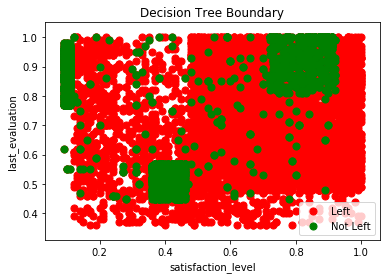

In [131]:
x = dataframe[list(dataframe.columns)[0]]
y = dataframe[list(dataframe.columns)[1]]
z = dataframe[list(dataframe.columns)[-1]]

not_left = []
new_x = []
j = 0
for i in z:
    if i == 1:
        not_left.append(y[j])
        new_x.append(x[j])
    j+=1    
plt.scatter(x,y,color = 'r',label = 'Left',s=50)
plt.scatter(new_x,not_left,color = 'g',label = 'Not Left',s=50)
plt.xlabel(list(dataframe.columns)[0])
plt.ylabel(list(dataframe.columns)[1])
plt.title('Decision Tree Boundary')
plt.legend()
plt.show()

# Part-5
### Plot a graph of training and validation error with respect to depth of your decision tree. Also plot the training and validation error with respect to number of nodes in the decision tree.

Depth  1  measured
Depth  2  measured
Depth  3  measured
Depth  4  measured
Depth  5  measured
Depth  6  measured
Depth  7  measured
Depth  8  measured
Depth  9  measured
Depth  10  measured
Depth  11  measured
Depth  12  measured
Depth  13  measured
Depth  14  measured
Depth  15  measured


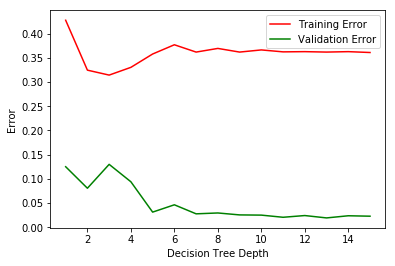

In [156]:
#Training Error
'''
Q2. ENTROPY with Continuous and Categorical
'''
impurity = 'entropy'
target_values = dataframe[target_attribute].unique()
depth = 1
depth_array = []
training_error = []
validation_error = []
while depth < 16:
    print("Depth ",depth," measured")
    TreeModel = BuildTree(depth,impurity,dataframe,target_attribute,target_values,None,columns,None,numcolumns,None)
    Accuracy,Precision,Recall,FScore = Measure(TreeModel,dataframe,numcolumns)
    training_error.append(1-Accuracy)
    Accuracy,Precision,Recall,FScore = Measure(TreeModel,test_data,numcolumns)
    validation_error.append(1-Accuracy)
    depth_array.append(depth)
    depth+=1
plt.plot(depth_array,training_error,color = 'r',label = 'Training Error')
plt.plot(depth_array,validation_error,color = 'g',label = 'Validation Error')
plt.xlabel('Decision Tree Depth')
plt.ylabel('Error')
plt.legend()
plt.show()
